# TODO:
- [ ] Create classifier
    - [x] Add top sites as feature
    - [x] Split dataset in chronological order
    - [ ] Replace LabelEncode by OneHotEncode
    - [x] Scale numeric features
    - [x] Change metric
    - [x] Add GridSearchCV
    - [x] Correct time by local Timezone
    - [ ] 2-steps classifiers (categorical, numerical)
    - [ ] Handle unseen labels
- [x] Create standalone script
    - [x] Module: add parser
- [ ] Comment Project
    - [x] Notebook: unbalanced data and choice for F1-score
    - [ ] Notebook: add hyperlink on Summary
    - [ ] Notebook: importance of retraining when confirmed a new unusual activity (ie: new location)
    - [ ] Notebook: review all comments
    - [ ] Notebook: remove TODO list
    - [ ] Notebook: clean code
    - [ ] Readme: create
    - [x] Module: add DocString

The present Jupyter Notebook explains the process of creating a predictive model to classify an user access as **Joe** or **not-Joe** using this [dataset](https://drive.google.com/file/d/1nATkzOZUe6w5IWcFNE3AakzBl-6P-5Hw/view?usp=sharing).

The sections are numbered as follows:

1. Load dataset
1. Data Exploration
    - Location
    - Gender
    - Language
    - Operating System
    - Browser
    - Time of the day
    - Day of the week
    - Day of the month
    - Month of the year
    - Duration
1. Predictive Model
    - Naïve Analysis
    - Decision Tree
1. Save
    - Export the Model
    - Run the Verify dataset
    - Export this Notebook

In [1]:
import catch_joe
from catch_joe import \
        extract_duration, extract_hour_local, extract_lengths, extract_sites_ratio, \
        categorize, encode_features, encode_joe, transform_features, print_scores

In [2]:
# import os
# from dtreeviz.trees import dtreeviz
# os.environ["PATH"] += os.pathsep + 'C:/Users/Diogo/anaconda3/Library/bin/graphviz'

from collections import Counter
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 1 Load dataset

In [4]:
file = './data/dataset.json'

df = pd.read_json(file)

# create target label as a separate column
user_id_joe = 0
df['joe'] = df['user_id'] == user_id_joe

print(df.shape)
df.head()

(80000, 10)


,browser,os,locale,user_id,gender,location,sites,time,date,joe
0,Firefox,Ubuntu,ru_RU,105,m,USA/Chicago,"[{'site': 'mail.google.com', 'length': 50}, {'...",09:03:00,2017-01-08,False
1,Firefox,Windows 8,pl-PL,11,m,USA/Chicago,"[{'site': 'meduza.org', 'length': 40}, {'site'...",13:57:00,2016-10-05,False
2,Chrome,Ubuntu,zh-CN,17,m,Singapore/Singapore,"[{'site': 'facebook.net', 'length': 74}, {'sit...",02:06:00,2017-03-28,False
3,Chrome,Windows 10,pt-BR,134,f,Australia/Sydney,"[{'site': 'verisign.com', 'length': 111}, {'si...",21:49:00,2017-06-25,False
4,Firefox,Windows 10,en-SG,92,f,USA/Chicago,"[{'site': 'live.com', 'length': 79}, {'site': ...",00:05:00,2016-02-10,False


In [5]:
# split dataset into train and test
# in chronological order (not random)

test_ratio = 0.1
df_later = df.sort_values(by='date').tail(int(test_ratio * df.shape[0]))

df = df.drop(df_later.index) # train dataset

df.shape

(72000, 10)

# 2 Data Exploration

## 2.1 Gender

The first feature to be explored is `gender`. Let's explore the hypothesis that Joe never changed their gender.

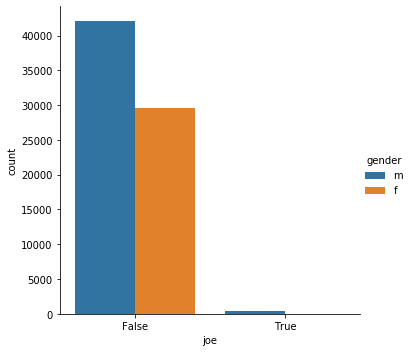

In [6]:
_ = sns.catplot(x='joe', hue='gender', kind='count', data=df)

It seems that Joe is a male, since there is no log on his name as female. This insight is useful to discard around 40% of the dataset.

## 2.2 Location

Let's now explore `location`. Unless Joe works in a cruising ship, probably he has limited variation of location around the globe so let's explore this hypothesis.

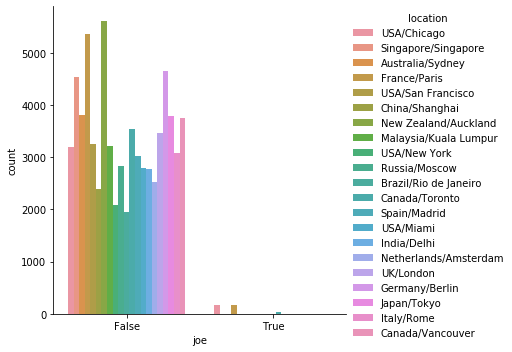

In [7]:
_ = sns.catplot(x='joe', hue='location', kind='count', data=df)

In [8]:
Counter(df[df['joe']]['location'])

Counter({'France/Paris': 164, 'USA/Chicago': 160, 'Canada/Toronto': 35})

Joe has access logs from Paris, Chicago and Toronto only. This is helpful to discard the other 18 locations.

## 2.3 Language

Let's now explore `locale`. It is rare to find an active polyglot so let's explore this hypothesis.

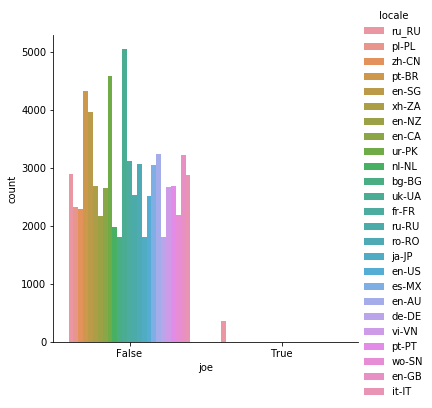

In [9]:
_ = sns.catplot(x='joe', hue='locale', kind='count', data=df)

In [10]:
Counter(df[df['joe']]['locale'])

Counter({'ru_RU': 359})

Despite the fact that Joe has many access from France, USA and Canada, his sessions are always in Russian language. Again, this eliminates all the other languages.

## 2.4 Operating System

If Joe is not a geek than he is probably using only one or two different `os`.

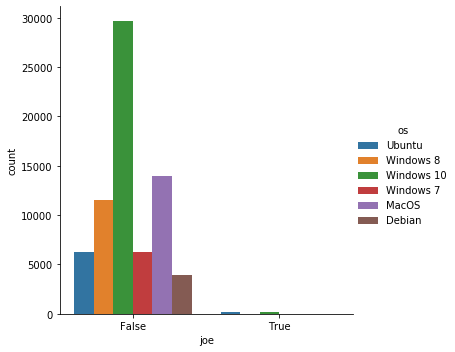

In [11]:
_ = sns.catplot(x='joe', hue='os', kind='count', data=df)

Indeed, Joe uses only Ubuntu and Windows 10. This rules out MacOS, Debian and the rest of the Microsoft's OS.

## 2.5 Browser

For the same reason explained before for the OS, Joe is probably using only a couple of `browsers`.

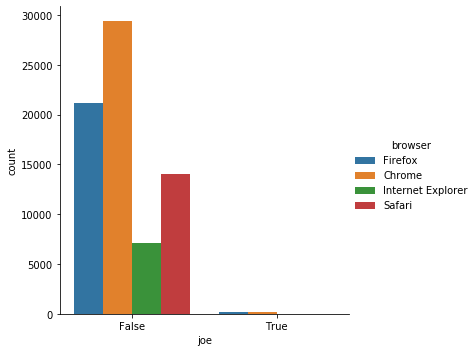

In [12]:
_ = sns.catplot(x='joe', hue='browser', kind='count', data=df)

Again, Joe uses only Firefox and Chrome, ruling out Internet Explorer and Safari.

## 2.6 Time of the day

Let's now verify the hypothesis that Joe accesses internet only in some specific hours of the day. Mind that there is a conversion from GMT to local timezone.

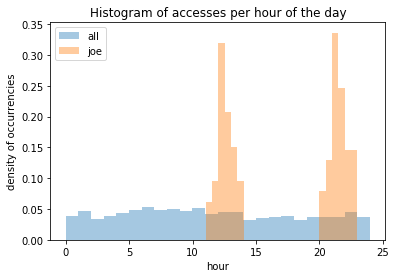

In [13]:
df['hour'] = extract_hour_local(df)

# plot
sns.distplot(df['hour'],            norm_hist=True, kde=False, rug=False, bins=24)
sns.distplot(df[df['joe']]['hour'], norm_hist=True, kde=False, rug=False, bins=24)
plt.legend(['all', 'joe'])
plt.title('Histogram of accesses per hour of the day')
_ = plt.ylabel('density of occurrencies')

Joe accesses internet only during lunch or dinner. Therefore, this is yet another relevant information to be used by our classifier.

## 2.7 Day of the week

Following the rationale from the previous subsection, let's verify the hypothesis that Joe accesses internet only in some specific days of the week.

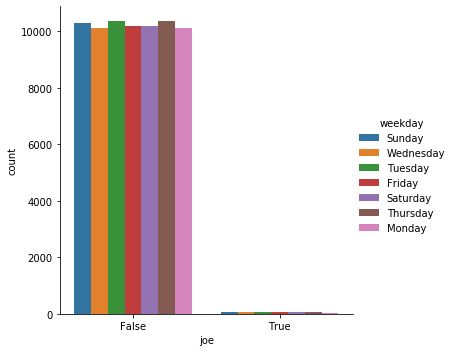

In [14]:
df['weekday'] = [date.day_name() for date in df['date']]

_ = sns.catplot(x='joe', hue='weekday', kind='count', data=df)

In [15]:
Counter(df[df['joe']]['weekday'])

Counter({'Saturday': 53,
         'Tuesday': 52,
         'Sunday': 53,
         'Friday': 54,
         'Wednesday': 49,
         'Monday': 46,
         'Thursday': 52})

There is no particular day of the week that shows an unusual history of access from Joe, so let's drop this feature.

## 2.8 Day of the month

Let's verify if Joe has different frequency of accesses along the days of the month.

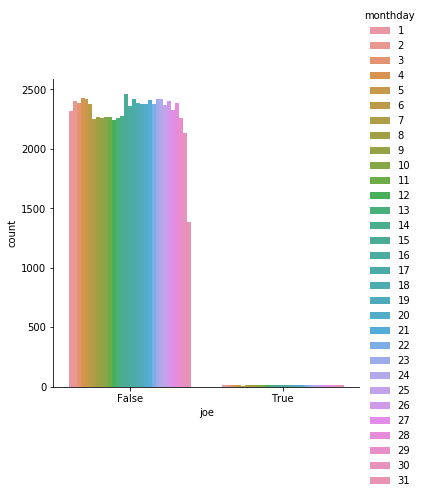

In [16]:
df['monthday'] = [date.day for date in df['date']]

_ = sns.catplot(x='joe', hue='monthday', kind='count', data=df)

There is no unusual pattern to be extracted out of the day of the month.

## 2.9 Month of the year

Now let's check if there is any useful pattern along the months of the year.

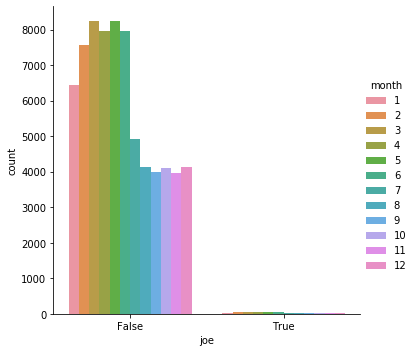

In [17]:
df['month'] = [date.month for date in df['date']]

_ = sns.catplot(x='joe', hue='month', kind='count', data=df)

Again, nothing useful from the month of the year.

## 2.10 Duration

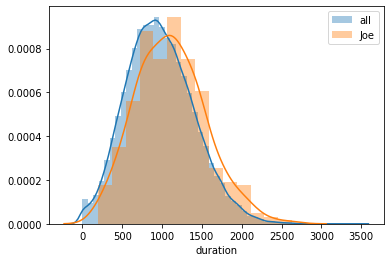

In [18]:
df['duration'] = extract_duration(df)

sns.distplot(df           ['duration'])
sns.distplot(df[df['joe']]['duration'])
_ = plt.legend(['all', 'Joe'])

Joe's duration of access is fit within the statistical boundaries of the population, which means that there is nothing unusual. Nonetheless, let's keep this feature since it is slightly off the population statistics so it might have some useful correlation with other features.

In [19]:
sites_joe = {site.get('site') for sites in df[df['joe']]['sites'] for site in sites}
print(len(sites_joe), 'sites accessed by Joe.')

1079 sites accessed by Joe.


In [20]:
sites_joe_list = list(sites_joe)    
df_sites_joe_length = extract_lengths(df[df['joe']], sites_joe_list)
df_sites_joe_length = df_sites_joe_length.mean().sort_values(ascending=False)
df_sites_joe_length

lenta.ru            126.693593
slack.com           120.256267
mail.google.com     119.462396
toptal.com          119.144847
vk.com              113.791086
                       ...    
ifsttar.fr            0.111421
investir.fr           0.111421
smartsheet.com        0.111421
jeuxcollector.fr      0.111421
gensyde.com           0.111421
Length: 1079, dtype: float64

In [21]:
df_sites_all_length = extract_lengths(df, sites_joe_list)
df_sites_all_length.mean().sort_values(ascending=False)

youtube.com             39.097875
toptal.com              31.048542
slack.com               30.621389
vk.com                  26.454833
lenta.ru                25.212111
                          ...    
cnrm-game.fr             0.016111
as.com                   0.015694
courtine.org             0.015375
adgrx.com                0.014389
foret-broceliande.fr     0.014375
Length: 1079, dtype: float64

The most accessed sites by Joe have links and lengths different than the population. So, this information is useful as well.

However, let's extract as features only the top acccessed sites in order to avoid overfitting and heavy computational cost.

In [22]:
top_sites = 50
joe_all_sites = list(df_sites_joe_length[:top_sites].index)
joe_top_sites = joe_all_sites[:top_sites]

# 3 Predictive Model

## 3.1 Naïve Bayes Analysis

The previously mentioned features are good enough to safely tell whenever is not Joe.

What if they are good enough to usem them independently as filters to discard them all until we have only joe's access left?

In orde to find this out, let's check how many logs match exactly the Joe's history for the categorical features. 

In [23]:
# define list of features to be used by the classifier

features_categorical = ['gender', 'os', 'browser', 'location', 'locale', 'hour']

features = features_categorical + ['duration'] + joe_top_sites

In [24]:
df_like_joe = df.copy()

filter_data = {feat: set(df[df['joe']][feat]) for feat in features_categorical}

for feature, valid_entries in filter_data.items():
    df_like_joe = df_like_joe[df_like_joe[feature].isin(valid_entries)]

    
# extract set of multiple website entries from Joe's logs
sites_joe = {site.get('site') for sites in df_like_joe['sites'] for site in sites}
df_like_joe = df_like_joe[list(map(lambda x:
                any(site.get('site') in sites_joe for site in x), df_like_joe['sites']))]
    
    
print('Original dataset contains', df.shape[0], 'logs.')
print('Like-Joe dataset contains', df_like_joe.shape[0], 'logs',
     "({0:.0%}).".format(df_like_joe.shape[0] / df.shape[0]))

Original dataset contains 72000 logs.
Like-Joe dataset contains 897 logs (1%).


Filtering out those logs that do not match Joe's history is enough to discard a large piece of the dataset.

But how many of the left logs are our Joe indeed?

In [25]:
count = Counter(df_like_joe['joe'])
print(count)

is_joe = np.asarray(list(count.values()))
is_joe = list(is_joe / is_joe.sum())

print('False and True accesses ratio from Joe:', ', '.join('{0:.1%}'.format(i) for i in is_joe))

Counter({False: 538, True: 359})
False and True accesses ratio from Joe: 40.0%, 60.0%


In [26]:
user_id_like_joe = set(df_like_joe['user_id'])
print(len(user_id_like_joe), 'total of user_id with same logs than Joe:', *user_id_like_joe)

5 total of user_id with same logs than Joe: 0 192 15 181 56


Despite the fact that the filter previously mentioned has efficiently removed most of the dataset, there are yet some logs from a few people with enough occurencies to be a majority over Joe. This is yet something to be tackled, since we don't want these people being taken as Joe.

## 3.2 Decision Tree

Maybe, the cross combination of restrictions across different features is enough to find Joe out of the other few people above. For instance, Joe might be the only one who uses Firefox (`browser`) on Windows 10 (`os`).

Let's create a simple Decision Tree, train it on the single-entries categorical features and check it's performance to detect Joe.

In [27]:
df_train = df.copy()

df_train, le = categorize(df_train, features_categorical)

y_train = encode_joe(df_train['user_id'] == user_id_joe)
df_train = transform_features(df_train, features, features_categorical, joe_top_sites, le)
X_train = df_train[features].values

Before creating our predictive model, let's calculate the Naïve performance. We know that the majority of the data is not from Joe so the Naïve classifier always assume that the result is 1 (not Joe).

In [28]:
y_pred = [1] * len(y_train)

print('Performance of Naïve on train dataset:')
print_scores(y_pred, y_train)

Performance of Naïve on train dataset:
99.5014% is the accuracy of the classifier.
0.0000% is the F1-score of the classifier.
0.00% of the Joe's accesses are detected.
0.00% of the detections are truly from Joe.


C:\Users\Diogo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As expected, the accuracy score is quite high because most of the data is not Joe (imbalanced). Moreover, precision and recall scores are obviously nulls because the Naïve blindly guessed it always as not Joe. As a consequence, our chosen metric will be F1-score, so that both precision and recall scores are going to be balanced.

In [29]:
# train model
model = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

print('Performance on train dataset:')
y_pred = model.predict(X_train)
print_scores(y_pred, y_train)

Performance on train dataset:
99.5056% is the accuracy of the classifier.
1.6575% is the F1-score of the classifier.
100.00% of the Joe's accesses are detected.
0.84% of the detections are truly from Joe.


In [30]:
# prepare test dataset
df_test = df_later.copy()
y_test = encode_joe(df_test['user_id'] == user_id_joe)
df_test = transform_features(df_later, features, features_categorical, sites_joe_list, le)
X_test = df_test[features].values

In [31]:
print('Performance on test dataset:')
y_pred = model.predict(X_test)
print_scores(y_pred, y_test)

Performance on test dataset:
99.4875% is the accuracy of the classifier.
0.0000% is the F1-score of the classifier.
0.00% of the Joe's accesses are detected.
0.00% of the detections are truly from Joe.


C:\Users\Diogo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The Decision Tree presents a slight increase of performance when compared to the Naïve guess. However, it is far from excellent since there are too wrong detections.

Before we move on to improve the performance, here is a question. How exactly does this Decision Tree above work in order to classify?

In order to help us answer this question, let's plot the nodes of the Decision Tree as a graph plot below.

In [32]:
# dtreeviz(model, X_train, y_train,
#                 target_name="target",
#                 feature_names=features,
#                 class_names=['Joe', 'not Joe'],
#         )

In [33]:
le['locale'].inverse_transform([18])

array(['ru_RU'], dtype=object)

The graph above shows that the Decision Tree queries the features in the following order:
1. If the language (`locale`) is less than 17.5 then is not Joe with 100% of certainty; else ...
1. If the language (`locale`) is more than 18.5 then is is not Joe with 100% of certainty; else ...
1. If the duration of access is less than 3.5 than it is Joe with 100% of certainty; else ...
1. We run out of questions so it guesses it is not Joe with roughly 10% of error.

Mind that `locale = 18` is the Russian language as coded by the `LabelEncoder`. Therefore, the first 2 questions above are mainly telling us that if the language of access is not Russian than it is not 
Joe for sure.

Another observtion is that the `duration` alone feature was not useful, as explained in the previous section. However, it became useful for the remaining cases that are exclusivelly Russian speakers.

Let's try the performance of other more sophisticted models.

In [34]:
# score_function = accuracy_score
score_function = lambda x, y: f1_score(x, y, pos_label=user_id_joe)

models = [
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    BaggingClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    
#     KNeighborsClassifier(n_neighbors=200),
    
#     QuadraticDiscriminantAnalysis(),
#     GaussianProcessClassifier(),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     SVC(),    
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     MLPClassifier(),
]

print('Test F1-score\t Model')

score_best = -np.Inf
best_model = None
for i_model, model in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = score_function(y_pred, y_test)
        
    print('{0:.3%}\t'.format(score), type(model).__name__)
    
    if score > score_best:
        score_best = score
        best_model = model
    


print('\nBest model:', type(best_model).__name__)

print('\nPerformance on train dataset:')
y_pred = best_model.predict(X_train)
print_scores(y_pred, y_train)

print('\nPerformance on test dataset:')
y_pred = best_model.predict(X_test)
print_scores(y_pred, y_test)

Test F1-score	 Model
61.654%	 DecisionTreeClassifier
60.294%	 AdaBoostClassifier
57.353%	 BaggingClassifier
75.294%	 RandomForestClassifier
53.333%	 GradientBoostingClassifier
4.255%	 GaussianNB

Best model: RandomForestClassifier

Performance on train dataset:
100.0000% is the accuracy of the classifier.
100.0000% is the F1-score of the classifier.
100.00% of the Joe's accesses are detected.
100.00% of the detections are truly from Joe.

Performance on test dataset:
99.7375% is the accuracy of the classifier.
75.2941% is the F1-score of the classifier.
72.73% of the Joe's accesses are detected.
78.05% of the detections are truly from Joe.


The best classifier performance trained above is much better than the previous Decision Tree to the point that it can be deployed.

# 4 Save

## 4.1 Exporting the model

Below we store the variables necesary to run a standalone script defined in the `catch_joe` module.

In [35]:
catch_joe_model_parameters = {
    'model': model,
    'encoder': le,
    'joe_top_sites': joe_top_sites,
    'features': features,
    'features_categorical': features_categorical,
}

with open('./model/catch_joe.pickle', 'wb') as f:
    pickle.dump(catch_joe_model_parameters, f)

## 4.2 Running the model on verify dataset

Let's use the model saved above through the standalone script.

In [36]:
# below is how to run the script through terminal command in here
# !python catch_joe.py -j ./data/verify.json


# alternatively, let's run it from the Jupyter Notebook
y_pred = catch_joe.main(file_json = './data/verify.json')

count = Counter(y_pred)
print(count)
percentage = count[0] / (count[1] + count[0])
print('{0:.2%} of the predictions are detected as Joe\'s accesses.'.format(percentage))

Counter({1: 22651, 0: 49})
0.22% of the predictions are detected as Joe's accesses.



## 4.3 Exporting this Notebook

The following code is to convert the present Jupyter Notebook into Python script. The script is the one under version control since we do not want to keep track of JSON codes internal to the `.ipynb` files.

In [37]:
# convert Notebook to Python for better version control
! jupyter nbconvert --to script "catch_joe_project.ipynb"

[NbConvertApp] Converting notebook catch_joe_project.ipynb to script
[NbConvertApp] Writing 16747 bytes to catch_joe_project.py
